In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import os

# -----------------------
# 1. Load CSV
# -----------------------
df = pd.read_csv('combined_crop_disease_labels.csv')

# Get number of classes
classes = sorted(df['label'].unique())
num_classes = len(classes)
print(f"Total classes: {num_classes}")

# -----------------------
# 2. Train-Test Split
# -----------------------
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# -----------------------
# 3. Data Generators
# -----------------------
image_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    class_mode='categorical',
    classes=classes,
    batch_size=batch_size,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    class_mode='categorical',
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    class_mode='categorical',
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)

# -----------------------
# 4. CNN Model
# -----------------------
def build_cnn(input_shape=(128, 128, 3), num_classes=num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = build_cnn()

# -----------------------
# 5. Compile Model
# -----------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------
# 6. Train Model
# -----------------------
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping: stop training if val_loss doesn’t improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',       # what to monitor
    patience=5,               # how many epochs to wait before stopping
    restore_best_weights=True # revert to best weights
)

# Optional: save the best model while training
checkpoint = ModelCheckpoint(
    'best_cnn_model.keras',   # filename
    monitor='val_loss',       # monitor validation loss
    save_best_only=True,      # only save when val_loss improves
    mode='min'
)

# Train model with callbacks
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, checkpoint]

)

# -----------------------
# 7. Evaluate on Test Set
# -----------------------
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# -----------------------
# 8. Save Model
# -----------------------
model.save('base_cnn_model2.keras')

Total classes: 26
Found 31031 validated image filenames belonging to 26 classes.
Found 7758 validated image filenames belonging to 26 classes.
Found 9698 validated image filenames belonging to 26 classes.


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 113s 116ms/step - accuracy: 0.1760 - loss: 2.8009 - val_accuracy: 0.4734 - val_loss: 1.6766
Epoch 2/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 113s 117ms/step - accuracy: 0.4072 - loss: 2.0431 - val_accuracy: 0.5874 - val_loss: 1.3019
Epoch 3/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 114s 117ms/step - accuracy: 0.4619 - loss: 1.9096 - val_accuracy: 0.5576 - val_loss: 1.6890
Epoch 4/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 116s 120ms/step - accuracy: 0.4682 - loss: 2.0519 - val_accuracy: 0.6042 - val_loss: 1.4399
Epoch 5/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 114s 118ms/step - accuracy: 0.4877 - loss: 2.2618 - val_accuracy: 0.6473 - val_loss: 1.3590
Epoch 6/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 114s 117ms/step - accuracy: 0.4996 - loss: 2.5133 - val_accuracy: 0.6253 - val_loss: 1.5870
Epoch 7/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 116s 120ms/step - accuracy: 0.5180 - loss: 2.5757 - val_accuracy: 0.5768 - val_loss: 2.6678
304/304 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.5986 - loss: 1.2735

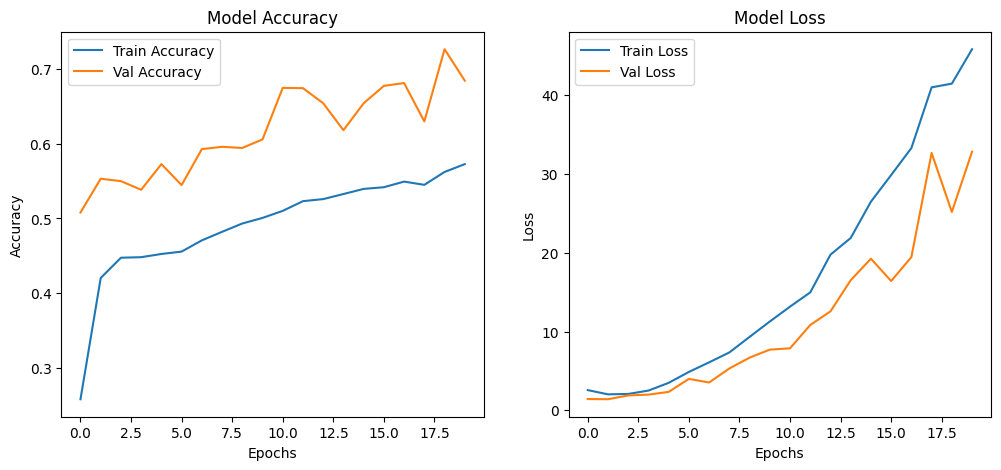

304/304 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step


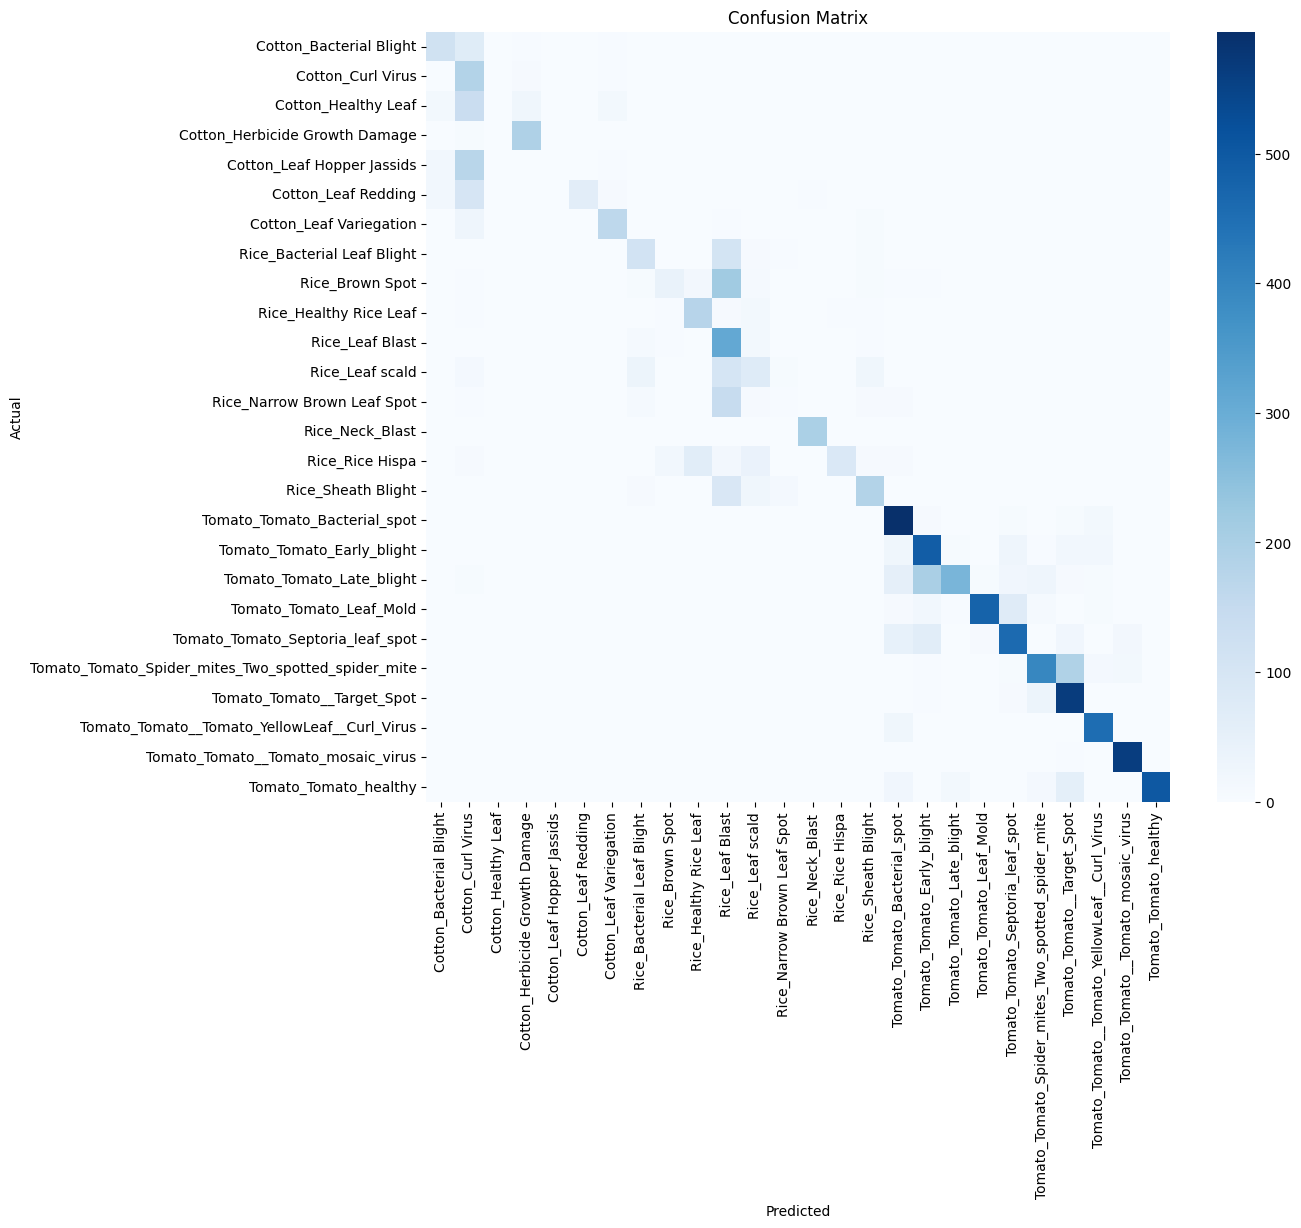


Classification Report:

                                                    precision    recall  f1-score   support

                           Cotton_Bacterial Blight       0.65      0.58      0.62       200
                                 Cotton_Curl Virus       0.25      0.93      0.40       200
                               Cotton_Healthy Leaf       0.00      0.00      0.00       200
                    Cotton_Herbicide Growth Damage       0.83      0.95      0.89       200
                        Cotton_Leaf Hopper Jassids       0.00      0.00      0.00       200
                               Cotton_Leaf Redding       0.98      0.32      0.48       200
                           Cotton_Leaf Variegation       0.82      0.81      0.82       200
                        Rice_Bacterial Leaf Blight       0.63      0.47      0.54       239
                                   Rice_Brown Spot       0.55      0.14      0.22       309
                            Rice_Healthy Rice Leaf    

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

# -----------------------
# 1. Plot Accuracy & Loss
# -----------------------
def plot_training_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

# -----------------------
# 2. Predictions on Test Set
# -----------------------
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# -----------------------
# 3. Confusion Matrix
# -----------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# -----------------------
# 4. Classification Report
# -----------------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# -----------------------
# 5. Macro & Weighted F1-score
# -----------------------
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

# -----------------------
# 6. Per-class sample count
# -----------------------
unique, counts = np.unique(y_true, return_counts=True)
print("\nTest set class distribution:")
for i, c in zip(unique, counts):
    print(f"{class_names[i]}: {c} samples")
